In [1]:
#import libraries
import os
import pandas as pd
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt


We will use it to access the auto-mpg dataset. You can find this dataset on the UCI machine learning repository. For this class, we will use a version of the Auto MPG dataset, where I added column headers. You can find my version at https://data.heatonresearch.com/.

UCI took this dataset from the StatLib library, which Carnegie Mellon University maintains. The dataset was used in the 1983 American Statistical Association Exposition. It contains data for 398 cars, including mpg, cylinders, displacement, horsepower , weight, acceleration, model year, origin and the car's name.

The following code loads the MPG dataset into a data frame:

In [14]:
# read data
pd.set_option('display.max_columns', 7)
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv",na_values=['?'])#na_values:if data replace null as ? or others
display(df[0:5])

,mpg,cylinders,displacement,...,year,origin,name
0,18.0,8,307.0,...,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,...,70,1,buick skylark 320
2,18.0,8,318.0,...,70,1,plymouth satellite
3,16.0,8,304.0,...,70,1,amc rebel sst
4,17.0,8,302.0,...,70,1,ford torino


In [15]:
#copy data, save original data
df2=df.copy()

In [16]:
#distribution,statistical information
df2.describe()

,mpg,cylinders,displacement,...,acceleration,year,origin
count,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,...,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,...,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,...,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,...,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,...,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,...,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,...,24.800000,82.000000,3.000000


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   year          398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


# Missing value

In [18]:
#check missing value
df2.apply(lambda x: sum(x.isnull()))

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

1. replace with median:

In [ ]:
med = df['horsepower'].median()#mean
df['horsepower'] = df['horsepower'].fillna(med)
                 
print(f"horsepower has na? {pd.isnull(df['horsepower']).values.any()}")

2.drop the value

In [ ]:
#DataFrame.dropna(*, axis=0, how=_NoDefault.no_default, thresh=_NoDefault.no_default, subset=None, inplace=False)
df = df.dropna() # 0:row, 1:column

3.KNN：KNNImputer
sklearn.impute.KNNImputer(*, missing_values=nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False, keep_empty_features=False)

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)
imputer.fit_transform(df2)
#can use selected columns
#df2[['horsepower', 'mpg', 'year']] = imputer.fit_transform(df2f2[['horsepower', 'mpg', 'year']])

4.Deep Neural Networks

In [ ]:
def fill_missing_numeric(df,current):
    df_x=df.drop(current)
    df_y = df[current]
    #missing row
    pred_mask = df[current].isnull()
    train_mask = ~pred_mask
    
    x = df_x[train_mask].values
    y = df_y[train_mask].values
    
    # Create train/test
    x_train, x_test, y_train, y_test = train_test_split(    
        x, y, test_size=0.25, random_state=42)
       
    # Build the neural network
    model = Sequential()
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(10, activation='relu')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                            patience=5, verbose=1, mode='auto', restore_best_weights=True)
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    
    # Prediction
    x2 = df_x[pred_mask].values
    pred = model.predict(x2)
    
    rtn = df.copy()
    rtn.loc[pred_mask, current] = pred
    return rtn

# outliers

Outliers are values that are unusually high or low. We typically consider outliers to be a value that is several standard deviations from the mean. Sometimes outliers are simply errors; this is a result of observation error. Outliers can also be truly large or small values that may be difficult to address. The following function can remove such values.

Key points: define outliers

<AxesSubplot:>

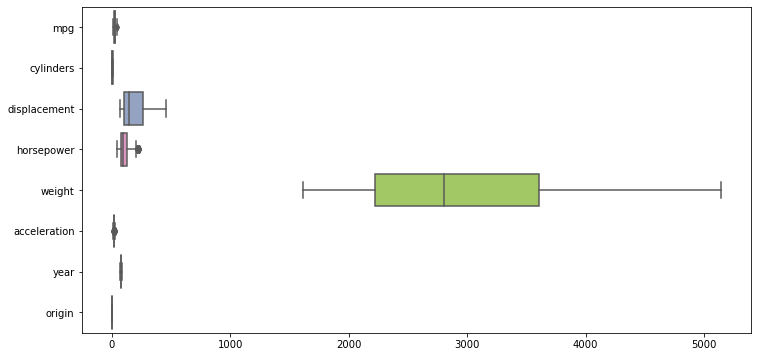

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
#ckeck outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df2, orient="h", palette="Set2", dodge=False)

In [ ]:
def get_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    return drop_rows

# feature selection

You must drop fields that are of no value to the response value

Simple Quality filtering

• Missing values
If a large fraction of your samples are missing data for a specific feature, just drop that feature
If a large fraction of feature values are missing for a sample, just drop that sample

• Low variance
If a feature’s values are all the same, drop it

• Domain expert judgement
Does the feature make sense for the problem?
Does the feature make sense for the model?

Filter methods

•Unsupervised approach
If a pair of features or more are highly informative or predictive of each other, just keeping one as a representative is sufficient

• Supervised approach
If a feature is highly informative or predictive of the output, it’s more important

• Scoring methods: mutual information, correlation

In [ ]:
#Missing values
miss_rate_df = df.isnull().sum().sort_values(ascending=False) / df.shape[0]

In [ ]:
#divergence
# 分析方差 
var_features = df.var().sort_values()
 
# 特征单值率
sigle_rate = {}
for var in df.columns:
    sigle_rate[var]=(df[var].value_counts().max()/df.shape[0])

In [ ]:
#方差膨胀因子VIF：
#方差膨胀因子也称为方差膨胀系数（Variance Inflation），用于计算数值特征间的共线性，一般当VIF大于10表示有较高共线性。
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 截距项
name = df.columns
x = np.matrix(df)
VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})


In [ ]:
import seaborn as sns
corr_df=df.corr()
# 热力图
sns.heatmap(corr_df)
# 剔除相关性系数高于threshold的corr_drop
threshold = 0.9
upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
corr_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

In [ ]:
#Chi2检验
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
x, y = load_iris(return_X_y=True)

x_new = SelectKBest(chi2, k=2).fit_transform(x, y)

In [ ]:
#信息量
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris
x, y = load_iris(return_X_y=True)
mutual_info_classif(x,y)

# Embedded methods

LASSO regression
The features that are least predictive will shrink to zero in response to the L1 penalt

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

x_new = SelectFromModel(LogisticRegression(penalty="l1", C=0.1)).fit_transform(x,  y)

Decision trees/Random forest 
The features chosen for splitting are picked to maximize decrease in Gini Impurity or Variance

In [ ]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance
from lightgbm import LGBMClassifier


model = LGBMClassifier()
model.fit(x, y)
plot_importance(model,  max_num_features=20, figsize=(10,5),importance_type='split')
plt.show()
feature_importance = pd.DataFrame({
        'feature': model.booster_.feature_name(),
        'gain': model.booster_.feature_importance('gain'),
        'split': model.booster_.feature_importance('split')
    }).sort_values('gain',ascending=False)

# Wrapper feature selection

穷举算法 (exhaustive search)，穷举算法是遍历所有可能的组合达到全局最优级，但是计算复杂度是2^n，一般是不太实际的算法。

Greedy Forward Feature Construction
前向搜索
前向搜索说白了就是，每次增量地从剩余未选中的特征选出一个加入特征集中，待达到阈值或者 n 时，从所有的 F 中选出错误率最小的。过程如下：

初始化特征集 F 为空。
扫描 i 从 1 到 n 如果第 i 个特征不在 F 中，那么特征 i 和F 放在一起作为 F_i (即 F_i=F\cup{i} )。 在只使用 F_i 中特征的情况下，利用交叉验证来得到 F_i 的错误率。
从上步中得到的 n 个 F_i 中选出错误率最小的 F_i ,更新 F 为 F_i 。
如果 F 中的特征数达到了 n 或者预定的阈值（如果有的话）， 那么输出整个搜索过程中最好的 ；若没达到，则转到 2，继续扫描。

Greedy Backward Feature Elimination
后向搜索
既然有增量加，那么也会有增量减，后者称为后向搜索。先将 F 设置为 {1,2,...,n} ，然后每次删除一个特征，并评价，直到达到阈值或者为空，然后选择最佳的 F 。

In [ ]:
#RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#递归特征消除法，返回特征选择后的数据
#参数estimator为基模型
#参数n_features_to_select为选择的特征个数
RFE(estimator=LogisticRegression(), n_features_to_select=2).fit_transform(iris.data, iris.target)

# Split Training and Validation

In [ ]:
# Usually a good idea to shuffle
df = df.reindex(np.random.permutation(df.index)) 

mask = np.random.rand(len(df)) < 0.8
trainDF = pd.DataFrame(df[mask])
validationDF = pd.DataFrame(df[~mask])

In [ ]:
#or
from sklearn.model_selection import train_test_split
Y_set = df2['name'].values
X_set = df2.drop(labels= "name" , axis = 1).values

# data spliting using 80:20 train test data ratio and randon seeding 6
X_train, X_test, Y_train, Y_test = train_test_split(X_set, Y_set, train_size=900,test_size=130, random_state=6)

# Encoding

Continuous Values
One common transformation is to normalize the inputs. It is sometimes valuable to normalize numeric inputs in a standard form so that the program can easily compare these two values. Consider if a friend told you that he received a 10-dollar discount. Is this a good deal? Maybe. But the cost is not normalized. If your friend purchased a car, the discount is not that good. If your friend bought lunch, this is an excellent discount!

Percentages are a prevalent form of normalization. If your friend tells you they got 10% off, we know that this is a better discount than 5%. It does not matter how much the purchase price was. One widespread machine learning normalization is the Z-Score:

z=x−μσ 

To calculate the Z-Score, you also need to calculate the mean(μ or  x¯ ) and the standard deviation (σ). 

In [ ]:
from scipy.stats import zscore
df2['mpg'] = zscore(df['mpg'])
display(df2)

Encoding Categorical Values as Dummies
The traditional means of encoding categorical values is to make them dummy variables. This technique is also called one-hot-encoding. Consider the following data set.

In [ ]:
dummies = pd.get_dummies(['a','b','c','d'],prefix='area')
print(dummies)
df.drop('area', axis=1, inplace=True)
df = pd.concat([df,dummies],axis=1)

Target Encoding for Categoricals
Target encoding is a popular technique for Kaggle competitions. Target encoding can sometimes increase the predictive power of a machine learning model. However, it also dramatically increases the risk of overfitting. Because of this risk, you must take care of using this method.

Generally, target encoding can only be used on a categorical feature when the output of the machine learning model is numeric (regression).

The concept of target encoding is straightforward. For each category, we calculate the average target value for that category. Then to encode, we substitute the percent corresponding to the category that the categorical value has. Unlike dummy variables, where you have a column for each category with target encoding, the program only needs a single column. In this way, target coding is more efficient than dummy variables.

# Shuffle and reindex

In [ ]:
import numpy as np
#np.random.seed(42) # Uncomment this line to get the same shuffle each time
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Sort

In [ ]:
df = df.sort_values(by='name', ascending=True)

# Grouping a Data Set

Grouping is a typical operation on data sets. Structured Query Language (SQL) calls this operation a "GROUP BY." Programmers use grouping to summarize data. Because of this, the summarization row count will usually shrink, and you cannot undo the grouping. Because of this loss of information, it is essential to keep your original data before the grouping.

In [ ]:
g = df.groupby('cylinders')['mpg'].mean()#sum or count.
#It might be useful to have these mean values as a dictionary.
d = g.to_dict()